In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


from gluonts.dataset.repository import get_dataset

/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)


In [2]:
dataset = get_dataset("electricity")


/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/dataset/common.py:264: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)
/tmp/ipykernel_1086989/3362768894.py:11: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))


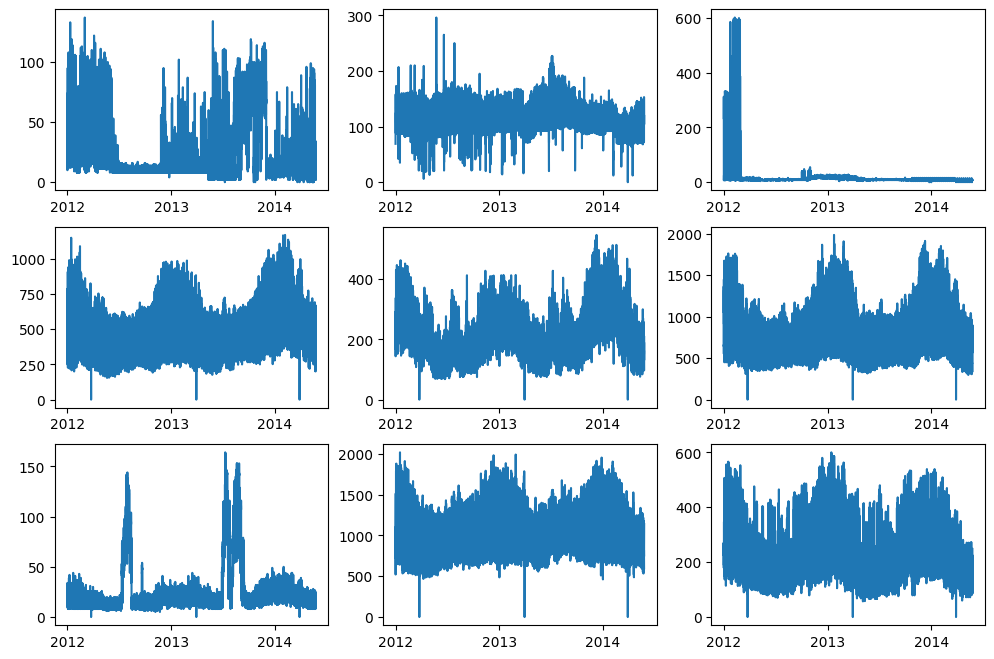

In [3]:
date_formater = mdates.DateFormatter("%Y")
fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

In [4]:
import torch
import torch.nn as nn
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [5]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        distr_output=StudentTOutput(),
        batch_norm: bool = False,
        scaling: Callable = mean_abs_scaling,
    ) -> None:
        super().__init__()

        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0

        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling

        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(
            self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1])
        )

        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])

    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin

    def forward(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
        nn_out = self.nn(scaled_context)
        nn_out_reshaped = nn_out.reshape(
            -1, self.prediction_length, self.hidden_dimensions[-1]
        )
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale

    def get_predictor(self, input_transform, batch_size=32):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
        )

In [6]:
import lightning.pytorch as pl

In [7]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        context = batch["past_target"]
        target = batch["future_target"]

        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(context)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [8]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]



In [9]:
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)


In [10]:
sum(np.prod(p.shape) for p in net.parameters())

144243

In [11]:
for p in net.parameters():
    print(p.shape)



torch.Size([96, 336])
torch.Size([96])
torch.Size([1152, 96])
torch.Size([1152])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


In [12]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)


In [13]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [14]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [15]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [16]:
batch_size = 32
num_batches_per_epoch = 50

In [17]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

In [18]:
trainer = pl.Trainer(max_epochs=10, devices=2)
trainer.fit(net, data_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for perfor

Epoch 9: |          | 50/? [00:00<00:00, 162.19it/s, v_num=2]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 50/? [00:00<00:00, 158.87it/s, v_num=2]


In [19]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [20]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

In [21]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [22]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)



In [30]:
forecasts_pytorch

[gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[13.495745 , 25.984465 , 28.444345 , ..., 19.165245 , 21.197712 ,
         20.712902 ],
        [13.039831 , 30.065247 , 27.23784  , ..., 16.559652 , 25.070011 ,
         16.732994 ],
        [12.0920725, 32.074047 , 26.951431 , ..., 20.291986 , 20.601223 ,
         20.259007 ],
        ...,
        [ 6.3144693, 26.203775 , 22.896877 , ..., 23.29262  , 27.206955 ,
         21.680628 ],
        [ 9.072409 , 22.59972  , 27.938644 , ..., 20.447441 , 24.584316 ,
         18.564838 ],
        [11.899094 , 20.726503 , 33.44385  , ..., 22.257315 , 21.162424 ,
         18.386723 ]], dtype=float32), start_date=Period('2014-05-26 20:00', 'h')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='1', samples=array([[120.76962 ,  99.74353 , 101.121254, ...,  94.576195, 106.04621 ,
         113.29786 ],
        [133.02356 , 104.413795, 123.007515, ...,  99.34862 , 118.23983 ,
         125.033676],
        [109.2990

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

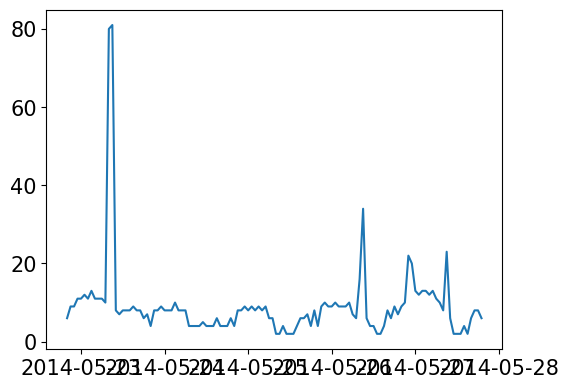

In [31]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()


In [32]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])



metrics_pytorch, _ = evaluator(tss_pytorch, forecasts_pytorch)
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()


Running evaluation: 2247it [00:00, 39991.69it/s]
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: R

,FeedForward
Coverage[0.1],7.584186e-02
Coverage[0.5],4.775627e-01
Coverage[0.9],9.098428e-01
MAE_Coverage,4.098428e-01
MAPE,1.524454e-01
MASE,9.879244e-01
MSE,3.879518e+06
MSIS,9.120898e+00
ND,9.521912e-02
NRMSE,8.257545e-01
